In [41]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Model
import scipy
import cv2
import numpy as np

In [3]:
# input_dir = os.path.join('C:/Users/Lydia/Desktop/New folder/Dataset_Phase1/')
# output_dir = os.path.join('C:/Users/Lydia/Desktop/New folder/Dataset_split/')

# splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.2))

Copying files: 10712 files [00:36, 294.07 files/s]


In [42]:
train_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Computer_Aided_Diagnosis_For_Chest_Radiograph/Dataset_split/train/')
test_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Computer_Aided_Diagnosis_For_Chest_Radiograph/Dataset_split/val/')

In [43]:
def image_generator(train_parent_directory, test_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size=(224,224),
                                                        batch_size=140,
                                                        class_mode='categorical',
                                                        subset='training')
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                                     target_size=(224,224),
                                                      batch_size=37,
                                                      class_mode='categorical')
    
    return train_generator, test_generator

In [44]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 8569 images belonging to 2 classes.
Found 2143 images belonging to 2 classes.


In [52]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [53]:
tfd = tfp.distributions
tfpl = tfp.layers

In [54]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/8569

model_bayes = Sequential([

        tfpl.Convolution2DReparameterization(input_shape=(224,224,3), filters=4, kernel_size=8, activation='relu',
                                               kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                               kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                               kernel_divergence_fn = divergence_fn,
                                               bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                               bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                               bias_divergence_fn = divergence_fn),
        MaxPooling2D(2,2),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                        kernel_divergence_fn = divergence_fn,
                                        bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                        bias_divergence_fn = divergence_fn
                                    ),
        tfpl.OneHotCategorical(2)

    ])
    
model_bayes.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_3  (None, 217, 217, 4)      1544      
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 108, 108, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 51, 51, 64)        18496     
                                                      

In [57]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [58]:
history_bayes = model_bayes.fit(
      train_generator,
      epochs=100,
      verbose=1)

Epoch 1/100
62/62 [==============================] - 203s 3s/step - loss: 1.0813 - accuracy: 0.6578
Epoch 2/100
62/62 [==============================] - 200s 3s/step - loss: 1.0653 - accuracy: 0.6511
Epoch 3/100
62/62 [==============================] - 200s 3s/step - loss: 1.0567 - accuracy: 0.6603
Epoch 4/100
62/62 [==============================] - 200s 3s/step - loss: 1.0493 - accuracy: 0.6602
Epoch 5/100
62/62 [==============================] - 200s 3s/step - loss: 1.0507 - accuracy: 0.6594
Epoch 6/100
62/62 [==============================] - 200s 3s/step - loss: 1.0427 - accuracy: 0.6610
Epoch 7/100
62/62 [==============================] - 200s 3s/step - loss: 1.0425 - accuracy: 0.6715
Epoch 8/100
62/62 [==============================] - 200s 3s/step - loss: 1.0279 - accuracy: 0.6774
Epoch 9/100
62/62 [==============================] - 199s 3s/step - loss: 1.0240 - accuracy: 0.6785
Epoch 10/100
62/62 [==============================] - 199s 3s/step - loss: 1.0211 - accuracy: 0.6830

62/62 [==============================] - 196s 3s/step - loss: 0.5108 - accuracy: 0.9838
Epoch 83/100
62/62 [==============================] - 194s 3s/step - loss: 0.5072 - accuracy: 0.9859
Epoch 84/100
62/62 [==============================] - 193s 3s/step - loss: 0.5055 - accuracy: 0.9866
Epoch 85/100
62/62 [==============================] - 193s 3s/step - loss: 0.5023 - accuracy: 0.9890
Epoch 86/100
62/62 [==============================] - 193s 3s/step - loss: 0.4963 - accuracy: 0.9911
Epoch 87/100
62/62 [==============================] - 194s 3s/step - loss: 0.4957 - accuracy: 0.9921
Epoch 88/100
62/62 [==============================] - 193s 3s/step - loss: 0.5003 - accuracy: 0.9877
Epoch 89/100
62/62 [==============================] - 193s 3s/step - loss: 0.4932 - accuracy: 0.9915
Epoch 90/100
62/62 [==============================] - 193s 3s/step - loss: 0.4894 - accuracy: 0.9932
Epoch 91/100
62/62 [==============================] - 192s 3s/step - loss: 0.4989 - accuracy: 0.9902
Epo

In [59]:
size = 224
dataset = []
label = []

pneumothorax_images = os.listdir('Pneumothorax/')
for i, image_name in enumerate(pneumothorax_images):
    image = cv2.imread('Pneumothorax/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)
X_train = X_train/255.
X_test = X_test/255.

In [61]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [62]:
_,train_acc = model_bayes.evaluate(X_train, y_train)
print('Accuracy of train datasets = ', (train_acc * 100.0), "%")

_,valid_acc = model_bayes.evaluate(X_test, y_test)
print('Accuracy of valid datasets = ', (valid_acc * 100.0), "%")

268/268 [==============================] - 32s 113ms/step - loss: 0.7881 - accuracy: 0.9560
Accuracy of train datasets =  95.60042023658752 %
67/67 [==============================] - 7s 98ms/step - loss: 0.7073 - accuracy: 0.9650
Accuracy of valid datasets =  96.50023579597473 %


67/67 [==============================] - 7s 96ms/step


<AxesSubplot:>

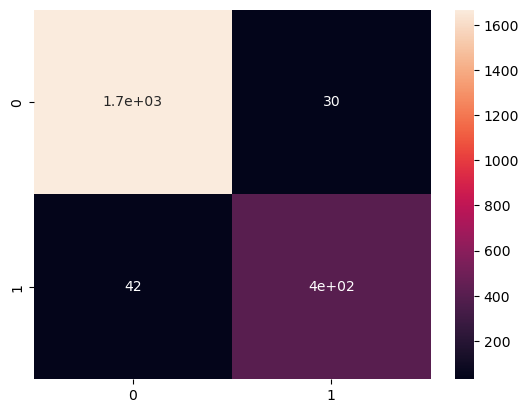

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)

In [64]:
pneumothorax_images_idx = np.where(y_pred == 1)[0]

In [65]:
predicted_as_para = []
for i in pneumothorax_images_idx:
    pneu_img = X_test[i]
    predicted_as_para.append(pneu_img)
    
predicted_as_para = np.array(predicted_as_para)

In [88]:
from matplotlib.patches import Rectangle
from skimage.feature.peak import peak_local_max

def plot_heatmap(img):
    pred = model_bayes.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    last_layer_weights = model_bayes.layers[-1].get_weights()[0]
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    last_conv_model = Model(model_bayes.input, model_bayes.get_layer("conv2d_11").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 64)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    heat_map[img[:,:,0] == 0] = 0 
     
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))


In [89]:
import random 
image = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[image])

img = predicted_as_para[image]
plt.imshow(predicted_as_para[img])

1/1 [==============================] - 0s 38ms/step


IndexError: list index out of range

In [106]:
model_bayes.save('bayesian_model.h5')

In [111]:
from tensorflow_probability.python.layers.conv_variational import Conv2DReparameterization
# from keras.models import load_model

loaded_model = tf.keras.models.load_model('bayesian_model.h5', custom_objects={'Conv2DReparameterization': Conv2DReparameterization})
# loaded_model.evaluate(X_test, y_test)

TypeError: 'str' object is not callable